# Crime Exploratry Data Analysis
=================================================================================================================================================

## Imports 
------------------------------------------------

In [1]:
import geopandas as gpd
import os
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point, Polygon
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

# Extenstion for matplotlib for better map plotting - !pip install matplotx
import matplotx 


## Loading of Data files to be used in Analysis
--------------------------------------------------------

In [2]:
# Load CSVs as DataFrames
df_stop_and_search = pd.read_csv("cleaned-data/cleaned_stop_and_search.csv")
df_street         = pd.read_csv("cleaned-data/cleaned_street.csv")
df_population    = pd.read_csv("supporting-data/population-served.csv")

# Create GeoDataFrame for stop & search
geometry_s = [Point(xy) for xy in zip(df_stop_and_search['Longitude'], df_stop_and_search['Latitude'])]
gdf_points_stop_and_search = gpd.GeoDataFrame(df_stop_and_search, geometry=geometry_s, crs="EPSG:4326")

# Create GeoDataFrame for street data
geometry_st = [Point(xy) for xy in zip(df_street['Longitude'], df_street['Latitude'])]
gdf_points_street = gpd.GeoDataFrame(df_street, geometry=geometry_st, crs="EPSG:4326")

# Loading M25 Boundary
m25_gdf = gpd.read_file('supporting-data/M25-shape/M25 Polygon.shp')
if m25_gdf.crs != "EPSG:4326":
    m25_gdf = m25_gdf.to_crs("EPSG:4326")

- Choosing plotting style for our charts

In [3]:
## Choosing plot style
plt.style.use(matplotx.styles.pitaya_smoothie["light"]) 

## Normalizing data
- For our crime rate, we want to be using crimes per 10,000 persons.
- This involves,
    - Joining street data with population data
    - creating a new column for crimes per 10,0000 persons

### Summary stats

In [4]:
## Summary stats
crime_type_by_force = df_street.groupby(['Police Force','Month']).size().reset_index(name='count')
df_crime_population = crime_type_by_force.merge(df_population,
                                                 left_on='Police Force',
                                                 right_on='Police Force',
                                                   how='left')
# Calculate crime rate per 1000 people
df_crime_population['crime_rate_per_10000'] = ((df_crime_population['count'] / 
                        (df_crime_population['Population (million)']*1000000)) * 10000).round(2)
summary_stats = df_crime_population.groupby(['Police Force'])['crime_rate_per_10000'].agg(
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).round(2)


In [5]:
# Sorting values by mean
means = summary_stats['mean'].sort_values(ascending=False)

# Create order list of police forces sorted by mean descending
order_forces = list(means.index)

# === Creating a colour palette to be used throughout
muted_pitaya_palette = [
    "#d67870", "#aeca7e", "#5fafc2",
    "#8a5fc3", "#d2518b", "#5e7fb8", "#c35e8d"
]

colour_map = dict(zip(order_forces, muted_pitaya_palette[:len(order_forces)]))


### Boxplot of summary statistics per region

C:\Users\zhary\AppData\Local\Temp\ipykernel_34860\1057351416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


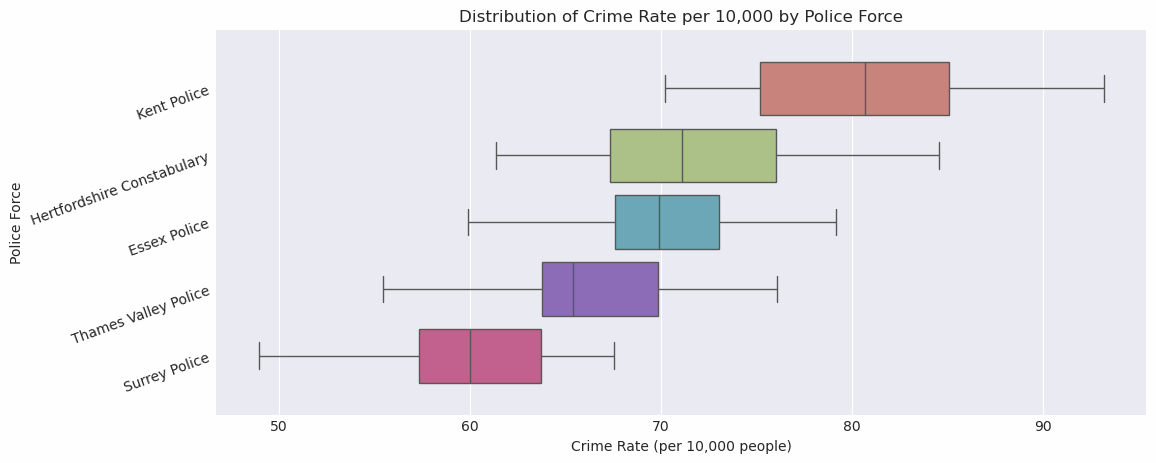

In [6]:
with plt.style.context(matplotx.styles.pitaya_smoothie["light"]):
    plt.figure(figsize=(12, 5))
    sns.boxplot(
        y='Police Force',
        x='crime_rate_per_10000',
        data=df_crime_population,
        orient='h',
        palette=colour_map,
        order=order_forces
    )
    ax = plt.gca()
    ax.margins(x=0.05, y=0.1)
    plt.title('Distribution of Crime Rate per 10,000 by Police Force')
    plt.ylabel('Police Force')
    plt.xlabel('Crime Rate (per 10,000 people)')
    plt.yticks(rotation=20, ha='right')

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size']   = 11
    
    plt.show()

### Bar chart - Mean Crime Rate per 10,000 by Police force

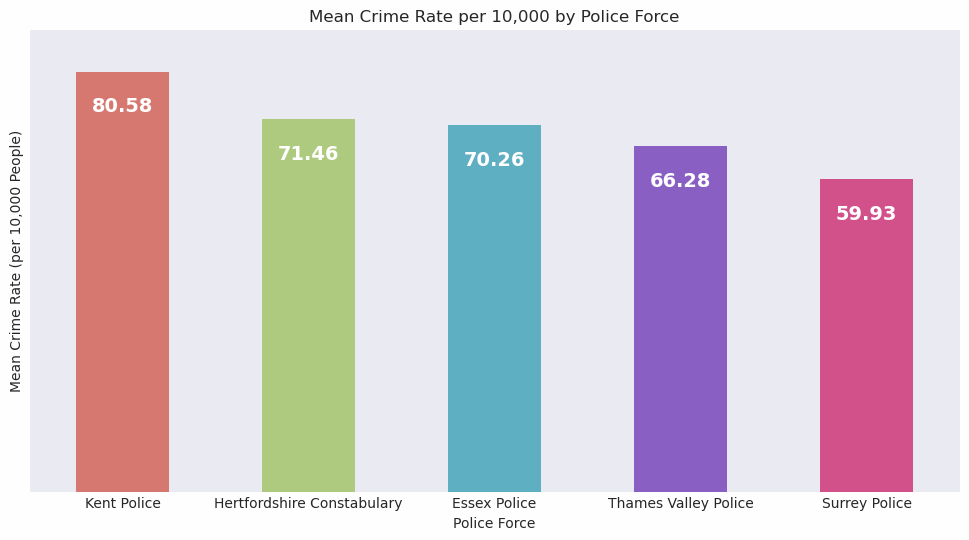

In [7]:
means = summary_stats['mean']
# Plot bar chart using your palette
ax = means.sort_values(ascending=False).plot(
    kind='bar',
    figsize=(12,6),
    title='Mean Crime Rate per 10,000 by Police Force',
    color = muted_pitaya_palette[:len(means)] 
)

matplotx.show_bar_values("{:.2f}")
plt.gca().margins(x=0.05, y=0.1)
plt.ylabel('Mean Crime Rate (per 10,000 People)')
plt.xlabel('Police Force')
plt.xticks(rotation=0, ha='center')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11
plt.show()


### Line Plot - Monthly Crime Rate by Police Force
- In the cell below, we prepare the dataframes by
    - Grouping data by Police Force and Month
    - Normalizing data by population size

In [8]:
# Group crime by month
df_crime_by_month_by_force = df_street.groupby(['Police Force','Month']).size().reset_index(name='count')
# Normalize by population
df_crime_by_month_by_force = df_crime_by_month_by_force.merge(df_population,
                                                 left_on='Police Force',
                                                    right_on='Police Force',
                                                    how='left')
df_crime_by_month_by_force['crime_rate_per_10000'] = ((df_crime_by_month_by_force['count'] /
                        (df_crime_by_month_by_force['Population (million)']*1000000)) * 10000).round(2)
df_crime_by_month_by_force.head()

,Police Force,Month,count,Population (million),Citation,crime_rate_per_10000
0,Essex Police,2023-10,14676,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,78.90
1,Essex Police,2023-11,13143,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,70.66
2,Essex Police,2023-12,12958,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,69.67
3,Essex Police,2024-01,12987,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,69.82
4,Essex Police,2024-02,12615,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,67.82


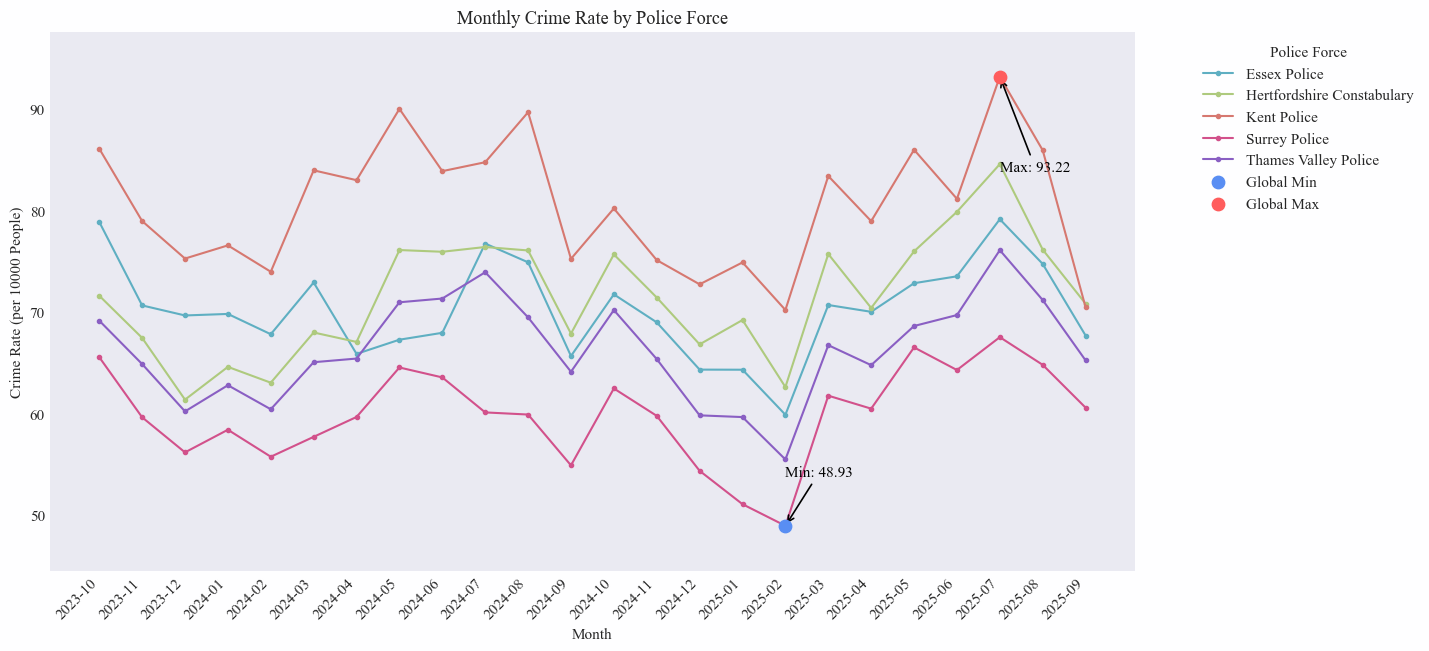

In [9]:
max_marker_colour = "#FF5D5D"  
min_marker_colour = "#598EF3"  

# Plot crime trend over months for each police force
plt.figure(figsize=(14, 7))
for force in df_crime_by_month_by_force['Police Force'].unique():
    subset = df_crime_by_month_by_force[df_crime_by_month_by_force['Police Force'] == force]
    plt.plot(subset['Month'], subset['crime_rate_per_10000'], marker='.', label=force,
             color=colour_map.get(force, "gray"))

# Plotting global minimum and maximum points
overall_min_idx = df_crime_by_month_by_force['crime_rate_per_10000'].idxmin()
overall_max_idx = df_crime_by_month_by_force['crime_rate_per_10000'].idxmax()

min_row = df_crime_by_month_by_force.loc[overall_min_idx]
max_row = df_crime_by_month_by_force.loc[overall_max_idx]

# Plot min & max markers
plt.scatter(min_row['Month'], min_row['crime_rate_per_10000'],
            color=min_marker_colour, s=80, zorder=5, label='Global Min')
plt.scatter(max_row['Month'], max_row['crime_rate_per_10000'],
            color=max_marker_colour, s=80, zorder=5, label='Global Max')

# Annotating min & max points
plt.annotate(f"Min: {min_row['crime_rate_per_10000']:.2f}",
             xy=(min_row['Month'], min_row['crime_rate_per_10000']),
             xytext=(min_row['Month'], min_row['crime_rate_per_10000']*1.1),
             color="black",
             arrowprops=dict(color="black", arrowstyle="->", lw=1.2)
            )

plt.annotate(f"Max: {max_row['crime_rate_per_10000']:.2f}",
             xy=(max_row['Month'], max_row['crime_rate_per_10000']),
             xytext=(max_row['Month'], max_row['crime_rate_per_10000']*0.9),
             color="black",
             arrowprops=dict(color="black", arrowstyle="->", lw=1.2)
            )
ax = plt.gca()
ax.margins(x=0.05, y=0.1)

plt.title('Monthly Crime Rate by Police Force')
plt.xlabel('Month')
plt.ylabel('Crime Rate (per 10000 People)')
plt.legend(title='Police Force', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid() 

plt.xticks(rotation=45, ha='right')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11

plt.show()

### Bar Plot - Crime Types in street data

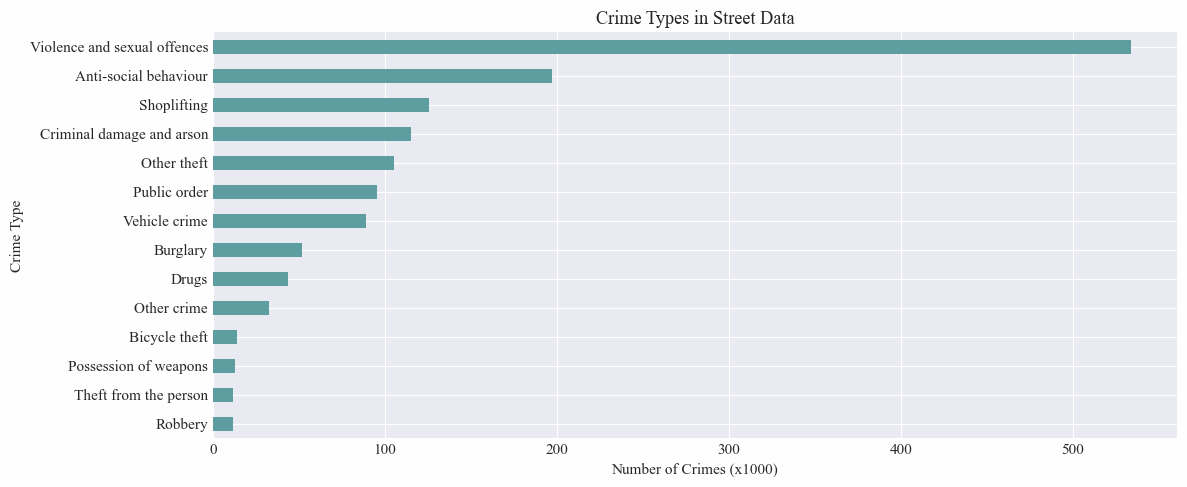

In [10]:
# Overall bar chart of crime types in street data
df_street_no = (df_street
                .groupby('Crime type')
                .size()
                .sort_values(ascending=True)
                / 1000)

plt.figure(figsize=(12, 5))

df_street_no.plot(kind='barh', color='#5f9ea0')
plt.title('Crime Types in Street Data')
plt.xlabel('Number of Crimes (x1000)')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

### Heatmap of top 10 crime types by Police Force

In [11]:
# Filter for top 10 crime types
top_10_crime_types = df_street['Crime type'].value_counts().nlargest(10).index
df_street_top10 = df_street[df_street['Crime type'].isin(top_10_crime_types)]

df_crimeType_policeForce = (
    df_street_top10.groupby([
                     'Police Force',
                     'Crime type']).size().reset_index(name='count')
)
# Normalize by population
df_crimeType_policeForce = df_crimeType_policeForce.merge(df_population,
                                                 left_on='Police Force',
                                                    right_on='Police Force',
                                                    how='left')
# Calculate crime rate per 10000 people
df_crimeType_policeForce['crime_rate_per_10000'] = ((df_crimeType_policeForce['count'] /
                        (df_crimeType_policeForce['Population (million)']*1000000)) * 1000).round(2)
df_crimeType_policeForce.sort_values(by='crime_rate_per_10000',ascending=False).head()

,Police Force,Crime type,count,Population (million),Citation,crime_rate_per_10000
29,Kent Police,Violence and sexual offences,138625,1.87,https://hmicfrs.justiceinspectorates.gov.uk/po...,74.13
9,Essex Police,Violence and sexual offences,124756,1.86,https://hmicfrs.justiceinspectorates.gov.uk/po...,67.07
49,Thames Valley Police,Violence and sexual offences,145225,2.43,https://hmicfrs.justiceinspectorates.gov.uk/po...,59.76
19,Hertfordshire Constabulary,Violence and sexual offences,65361,1.20,https://hmicfrs.justiceinspectorates.gov.uk/po...,54.47
39,Surrey Police,Violence and sexual offences,59933,1.20,https://hmicfrs.justiceinspectorates.gov.uk/po...,49.94


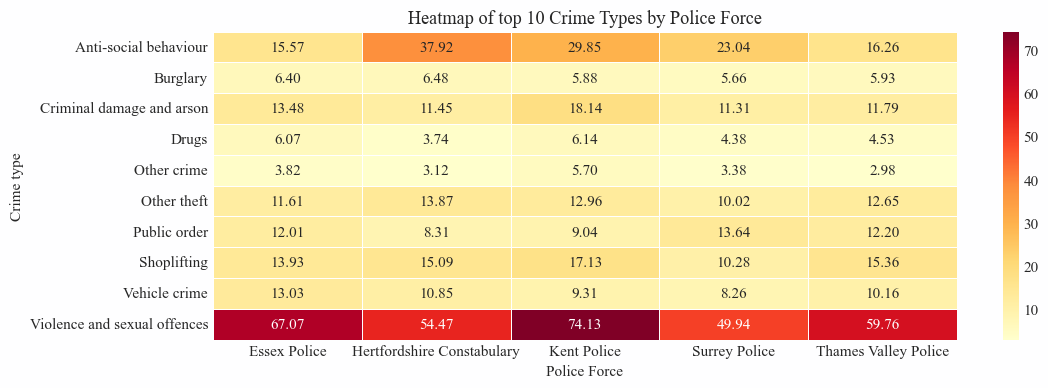

In [12]:
# Pivot for heatmap
pivot_df = df_crimeType_policeForce.pivot(index='Crime type',
                                           columns='Police Force',
                                             values='crime_rate_per_10000').fillna(0)

plt.figure(figsize=(12, 4))    
sns.heatmap(pivot_df,
            cmap='YlOrRd',      
            annot=True,           
            fmt='.2f',              
            linewidths=.5)  
      
plt.title('Heatmap of top 10 Crime Types by Police Force')
plt.ylabel('Crime type')
plt.xlabel('Police Force')
plt.xticks(rotation=0, ha='center')  
plt.yticks(rotation=0)    

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11

plt.show()

### Bar Plot - Stop & Search Counts by Police Force 

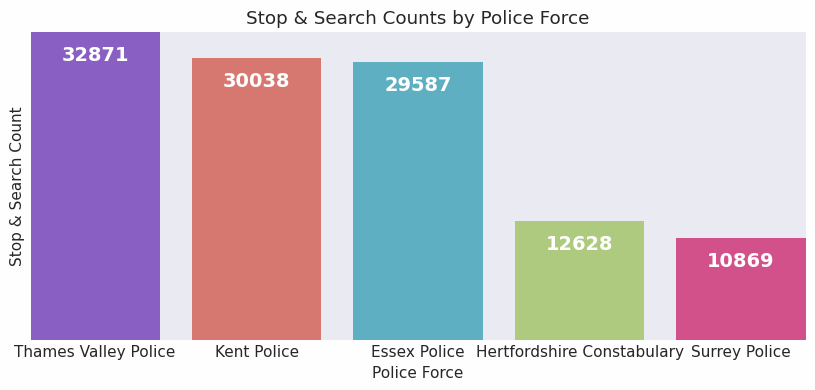

In [13]:
df_stop_and_search_by_Force = df_stop_and_search.groupby(['Police Force']).size().reset_index(name='count')
df2 = df_stop_and_search_by_Force.sort_values(by='count', ascending=False)

# Apply the style (if not already)
plt.style.use(matplotx.styles.pitaya_smoothie["light"])

# Plot using matplotlib directly (so you can assign bar colours individually)
fig, ax = plt.subplots(figsize=(10,4))
bars = ax.bar(
    df2['Police Force'],
    df2['count'],
    color=[ colour_map.get(name, '#999999') for name in df2['Police Force'] ]
)

ax.set_title('Stop & Search Counts by Police Force')
ax.set_xlabel('Police Force')
ax.set_ylabel('Stop & Search Count')
ax.set_xticks(range(len(df2['Police Force'])))
ax.set_xticklabels(df2['Police Force'], rotation=45, ha='right')

matplotx.show_bar_values()
plt.xticks(rotation=0, ha='center')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11
plt.show()

### Hotspot mapping of Street data and Stop & Search data
-------------------------------------------------------
This section will contain the following charts,

1. Hotspot Analysis of Street Crime Incidents with Police Boundaries
2. Hotspot Analysis - Comparison of Street Crime hotspots with Stop and Search Hotspots

- Below is a unction to load and create polygons for police force boundaries

In [14]:
# Namespace for KML parsing
NS = {
    'kml': 'http://earth.google.com/kml/2.1'
}

def parse_kml_polygons(file_path, source_column=True):
    print(f"Parsing (file) {file_path}")
    tree = ET.parse(file_path)
    root = tree.getroot()

    records = []

    # Iterate over all Placemark elements
    for placemark in root.findall('.//kml:Placemark', NS):
        name = placemark.find('kml:name', NS)
        name = name.text if name is not None else None

        # Find all Polygon elements inside the placemark
        for poly in placemark.findall('.//kml:Polygon', NS):
            outer = poly.find('.//kml:outerBoundaryIs/kml:LinearRing/kml:coordinates', NS)
            if outer is None:
                continue
            coord_text = outer.text.strip()

            coords = []
            for part in coord_text.split():
                comps = part.split(',')
                if len(comps) < 2:
                    continue
                lon = float(comps[0])
                lat = float(comps[1])
                coords.append((lon, lat))
            if not coords:
                continue
            polygon = Polygon(coords)
            rec = {
                'name': name,
                'geometry': polygon
            }
            if source_column:
                rec['source_file'] = os.path.basename(file_path)
            records.append(rec)

    if not records:
        print("  → no polygons found in", file_path)
        return None

    gdf = gpd.GeoDataFrame(records, geometry='geometry')
    return gdf

# Usage loop
kml_folder = 'force-kmls'
kml_files = [os.path.join(kml_folder, f) for f in os.listdir(kml_folder) if f.lower().endswith('.kml')]

all_gdfs = []
for fpath in kml_files:
    gdf = parse_kml_polygons(fpath)
    if gdf is not None:
        all_gdfs.append(gdf)

if all_gdfs:
    final_gdf = pd.concat(all_gdfs, ignore_index=True)
    final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry')
    print("Successfully loaded boundaries - total records:", len(final_gdf))
else:
    print("No boundaries were loaded.")


Parsing (file) force-kmls\essex.kml
Parsing (file) force-kmls\hertfordshire.kml
Parsing (file) force-kmls\kent.kml
Parsing (file) force-kmls\surrey.kml
Parsing (file) force-kmls\thames-valley.kml
Successfully loaded boundaries - total records: 5


- Displaying the empty region map

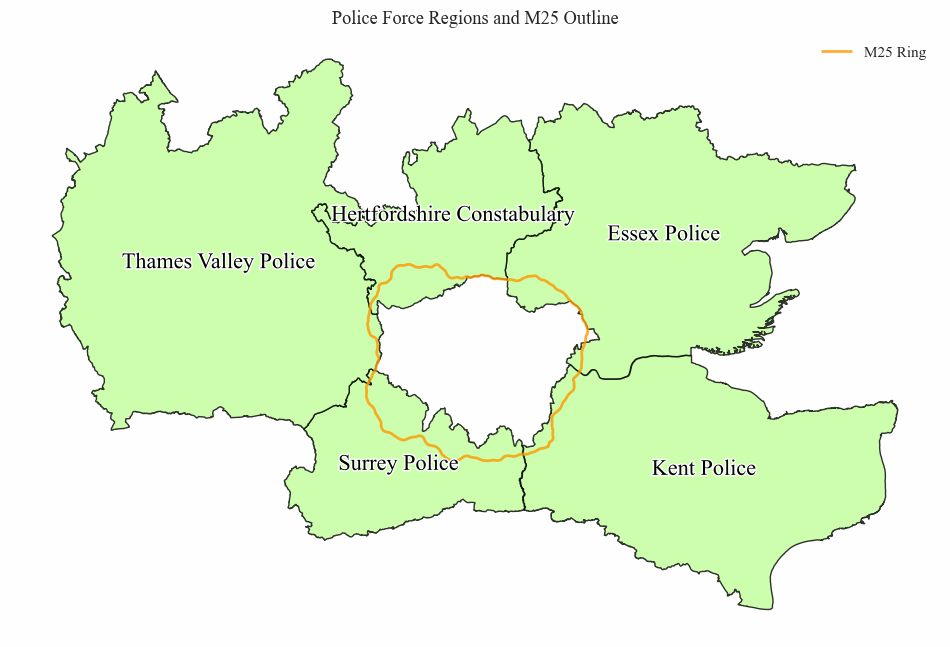

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the regions (e.g., police boundaries)
final_gdf.plot(ax=ax,
               edgecolor='black',
               facecolor="#c0ff99",
               alpha=0.8,
               linewidth=1)

# Plot the M25 ring boundary
m25_gdf.boundary.plot(ax=ax,
                      color="#FF9900",
                      linewidth=2,
                      label='M25 Ring',
                      alpha=0.8)

# Add labels for each region
for idx, row in final_gdf.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    label = row.get('name', None)  # adjust 'name' if your field is different
    if label:
        txt = ax.text(x, y, label,
                      ha='center', va='center',
                      fontsize=16, color='black')
        # add white stroke around text for contrast:
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground="white"),
                              path_effects.Normal()])

ax.legend()
ax.set_title('Police Force Regions and M25 Outline')
ax.set_axis_off()

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11

plt.show()

1. Hotspot Analysis of Street Crime Incidents with Police Boundaries

Index(['name', 'geometry', 'source_file'], dtype='object')
0                   Essex Police 
1     Hertfordshire Constabulary 
2                    Kent Police 
3                  Surrey Police 
4           Thames Valley Police 
Name: name, dtype: object


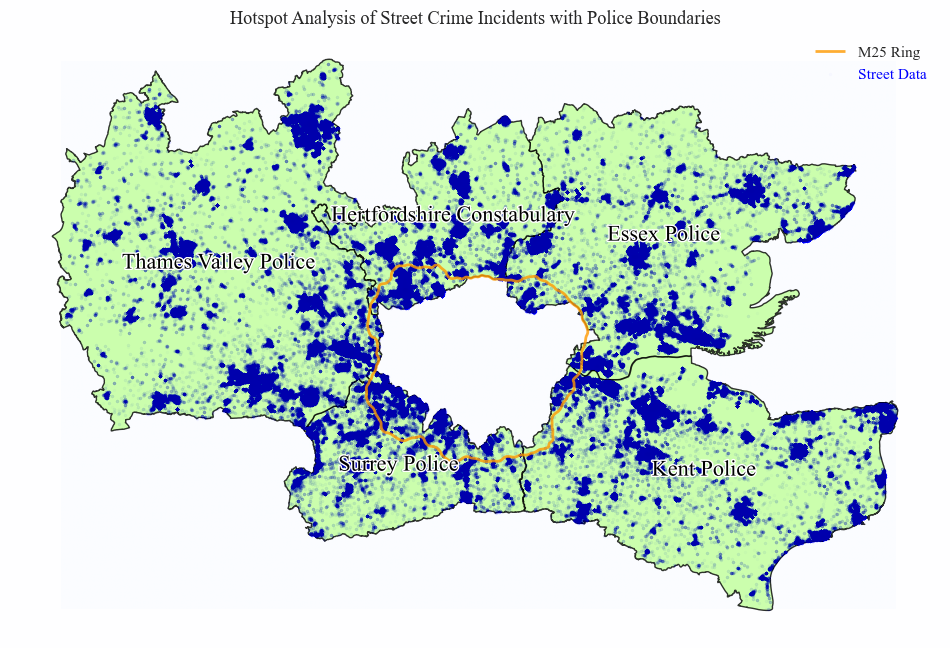

In [16]:

fig, ax = plt.subplots(1,1, figsize=(12,12))

final_gdf.plot(ax=ax,
               edgecolor='black',
               facecolor="#c0ff99",
               alpha=0.8,
               linewidth=1)

# Now your heatmap + points as before
x_st = df_street['Longitude'].values
y_st = df_street['Latitude'].values
heat_st, xedges_st, yedges_st = np.histogram2d(x_st, y_st, bins=200)
extent_st = [xedges_st[0], xedges_st[-1], yedges_st[0], yedges_st[-1]]
ax.imshow(heat_st.T, extent=extent_st, origin='lower', cmap='Blues', alpha=0.4)

m25_gdf.boundary.plot(ax=ax, color="#FF9900", linewidth=2, label='M25 Ring', alpha=0.8)

gdf_points_street.plot(ax=ax, markersize=3, color='blue', alpha=0.01, label='Street Data')


# Add labels for each region
for idx, row in final_gdf.iterrows():
    # get the centroid (or you could use representative point)
    x, y = row['geometry'].centroid.coords[0]
    label = row.get('name', None)  # adjust 'name' to whatever your column is
    if label:
        ax.text(x, y, label,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                #fontweight='',
                color="#000000",
                path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2,
                                                                   foreground="white")])
        # the path_effects part puts a white outline around the text for better contrast
print(final_gdf.columns)
print(final_gdf['name'].head())


# Legend
leg = ax.legend()
# Now set the legend text colour for the “Street Data” label
for text in leg.get_texts():
    if text.get_text() == 'Street Data':
        text.set_color('blue')

ax.set_title('Hotspot Analysis of Street Crime Incidents with Police Boundaries')
ax.set_axis_off()

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11

plt.show()


2. Hotspot Analysis - Comparison of Street Crime hotspots with Stop and Search Hotspots

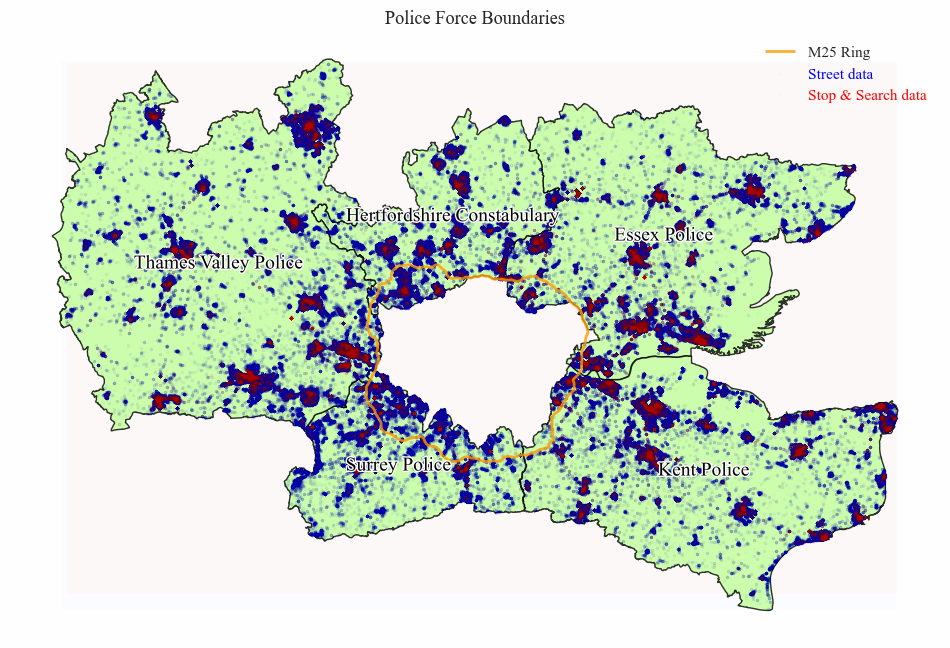

In [17]:
# Plot your base map
fig, ax = plt.subplots(1,1, figsize=(12,12))
final_gdf.plot(ax=ax,
               edgecolor='black',
               facecolor="#c0ff99",
               alpha=0.8,
               linewidth=1)
ax.set_title('Police Force Boundaries')
ax.set_axis_off()

# Plot the M25 ring boundary
m25_gdf.boundary.plot(ax=ax,
                      color="#FF9900",
                      linewidth=2,
                      label='M25 Ring',
                      alpha=0.8)

# Heatmap + points for Street data
x_st = df_street['Longitude'].values
y_st = df_street['Latitude'].values
heat_st, xedges_st, yedges_st = np.histogram2d(x_st, y_st, bins=200)
extent_st = [xedges_st[0], xedges_st[-1], yedges_st[0], yedges_st[-1]]
ax.imshow(heat_st.T, extent=extent_st, origin='lower', cmap='Blues', alpha=0.4)
gdf_points_street.plot(ax=ax, markersize=3, color='blue', alpha=0.01, label='Street data')

# Heatmap + points for Stop & Search
x_ss = df_stop_and_search['Longitude'].values
y_ss = df_stop_and_search['Latitude'].values
heat_ss, xedges_ss, yedges_ss = np.histogram2d(x_ss, y_ss, bins=200)
extent_ss = [xedges_ss[0], xedges_ss[-1], yedges_ss[0], yedges_ss[-1]]
ax.imshow(heat_ss.T, extent=extent_ss, origin='lower', cmap='Reds', alpha=0.5)
gdf_points_stop_and_search.plot(ax=ax, markersize=3, color='red', alpha=0.01, label='Stop & Search data')

for idx, row in final_gdf.iterrows():
    # get the centroid (or you could use representative point)
    x, y = row['geometry'].centroid.coords[0]
    label = row.get('name', None)  # adjust 'name' to whatever your column is
    if label:
        ax.text(x, y, label,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14,
                #fontweight='',
                color="#000000",
                path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2,
                                                                   foreground="white")])

leg = ax.legend()
# Now set the legend text colour for the “Street Data” label
for text in leg.get_texts():
    if text.get_text() == 'Street data':
        text.set_color('blue')
    if text.get_text() == 'Stop & Search data':
        text.set_color('red')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 11      
        
plt.show()